In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
from POSEIDON.utility import read_high_res_data_deprecate
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

/home/ruizhew/.conda/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py:972: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if spectrum_type is "emission":
/home/ruizhew/.conda/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py:995: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif spectrum_type is "transmission":


In [2]:
from POSEIDON.core import define_model, wl_grid_constant_R

R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data_deprecate

# ***** Define model *****#

model_name = "H2O, CO, CH4, NH3"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["H2O", "CO", "CH4", "NH3"]  # H2O, CO as in Brogi & Line

high_res_params = ["K_p", "V_sys", "log_a"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 400  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_H2O' 'log_CO' 'log_CH4'
 'log_NH3' 'K_p' 'V_sys' 'log_a']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
H2O done
CO done
CH4 done
NH3 done
Opacity pre-interpolation complete.


In [3]:
# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-4, -4, -4, -4]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [0.2, 0.1, 0.17, -1.39, 1, 1500]
)  # a1, a2, log_P1, log_P2, log_P3, T_top
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1e-5
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="direct_emission",
)

In [49]:
def make_injection_data(
    data,
    data_dir,
    name,
    wl,
    planet_spectrum,
    K_p,
    V_sys,
    method,
    a=1,
    W_conv=None,
    star_spectrum=None,
):
    residuals = data["residuals"]
    flux = data["flux_blaze_corrected"]
    wl_grid = data["wl_grid"]

    phi = data["phi"]
    if "V_bary" in data.keys():
        V_bary = data["V_bary"]
    else:
        V_bary = np.zeros_like(phi)

    nord, nphi, npix = residuals.shape
    planet_spectrum = gaussian_filter1d(planet_spectrum, W_conv)
    emission = star_spectrum is not None

    if emission:
        spectrum_type = "emission"
        star_spectrum = gaussian_filter1d(star_spectrum, W_conv)
    else:
        spectrum_type = "transmission"
        transit_weight = data["transit_weight"]
        max_transit_depth = np.max(1 - transit_weight)
    # Time-resolved total radial velocity
    radial_velocity = V_sys + V_bary + K_p * np.sin(2 * np.pi * phi)
    # V_sys is an additive term around zero
    delta_lambda = radial_velocity * 1e3 / constants.c  # delta lambda, for shifting

    F_p_F_s = np.zeros((nord, nphi, npix))
    F_p = np.zeros((nord, nphi, npix))

    for i in range(nord):  # Nord = 44 This takes 2.2 seconds to complete
        wl_slice = wl_grid[i].copy()  # Cropped wavelengths
        for j in range(nphi):  # This for loop takes 0.025 seconds Nphi = 79
            wl_shifted_p = wl_slice * (1.0 - delta_lambda[j])
            if emission:
                F_p_F_s[i, j, :] = np.interp(
                    wl_shifted_p, wl, planet_spectrum
                ) / np.interp(wl_slice, wl, star_spectrum)
            else:
                F_p[i, j, :] = (
                    -np.interp(wl_shifted_p, wl, planet_spectrum)
                    * (1 - transit_weight[j])
                    / max_transit_depth
                    + 1
                )

    if emission:
        # data_injected = (1 + F_p_F_s) * (flux - residuals)
        data_injected = (1 + F_p_F_s) * (flux)
    else:
        data_injected = F_p * flux

    add_high_res_data(
        data_dir, name, data_injected, wl_grid, phi, transit_weight=None, overwrite=True
    )

    prepare_high_res_data(data_dir, name, spectrum_type, method, overwrite=True)

    return

In [50]:
data_dir = "./data/WASP-77Ab/"
names = ["IGRINS"]
data = read_high_res_data(data_dir, names)
inject_dir = "./data/WASP-77Ab-injection/"
inject_name = "H2O_CO_CH4_NH3"
for name in names:
    make_injection_data(
        data[name],
        inject_dir,
        inject_name,
        wl,
        spectrum,
        -200,
        -20,
        "sysrem_2022",
        a=1,
        W_conv=1,
        star_spectrum=star["F_star"] * R_s**2,
    )

Overwriting data at ./data/WASP-77Ab-injection/H2O_CO_CH4_NH3/data_raw.hdf5
Overwriting data at ./data/WASP-77Ab-injection/H2O_CO_CH4_NH3/data_processed.hdf5
[[[ 2.07978367e-02  3.92282732e-02  7.64890015e-02 ...  4.96545080e-01
    5.06629381e-01  5.15628562e-01]
  [ 2.91997017e-02  4.06359740e-02  7.26114723e-02 ...  5.04947438e-01
    5.11490527e-01  5.26667394e-01]
  [ 2.12903190e-02  4.70581739e-02  7.73199869e-02 ...  5.02930690e-01
    5.07645745e-01  5.26386688e-01]
  ...
  [ 1.33944224e-02  2.34266426e-02  4.46587881e-02 ...  5.22103598e-01
    5.19124469e-01  5.31548360e-01]
  [ 1.08749294e-02  2.50853257e-02  4.03182367e-02 ...  5.35931574e-01
    5.28183165e-01  5.35803777e-01]
  [ 1.03446708e-02  2.49582250e-02  4.45826315e-02 ...  5.17005737e-01
    5.17602954e-01  5.31813067e-01]]

 [[ 3.71081773e-01  3.48813696e-01  3.34319719e-01 ...  5.04089047e-01
    4.93189454e-01  4.81624904e-01]
  [ 3.65172821e-01  3.50917930e-01  3.37966388e-01 ...  5.03965012e-01
    4.83439492

In [ ]:
from PyAstronomy import pyasl
import POSEIDON

data = read_high_res_data(inject_dir, names=[inject_name])

In [ ]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # gaussian_filter1d(
        #     spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 1000), 400), 5
        # ),
        spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 22.00926923751831 seconds


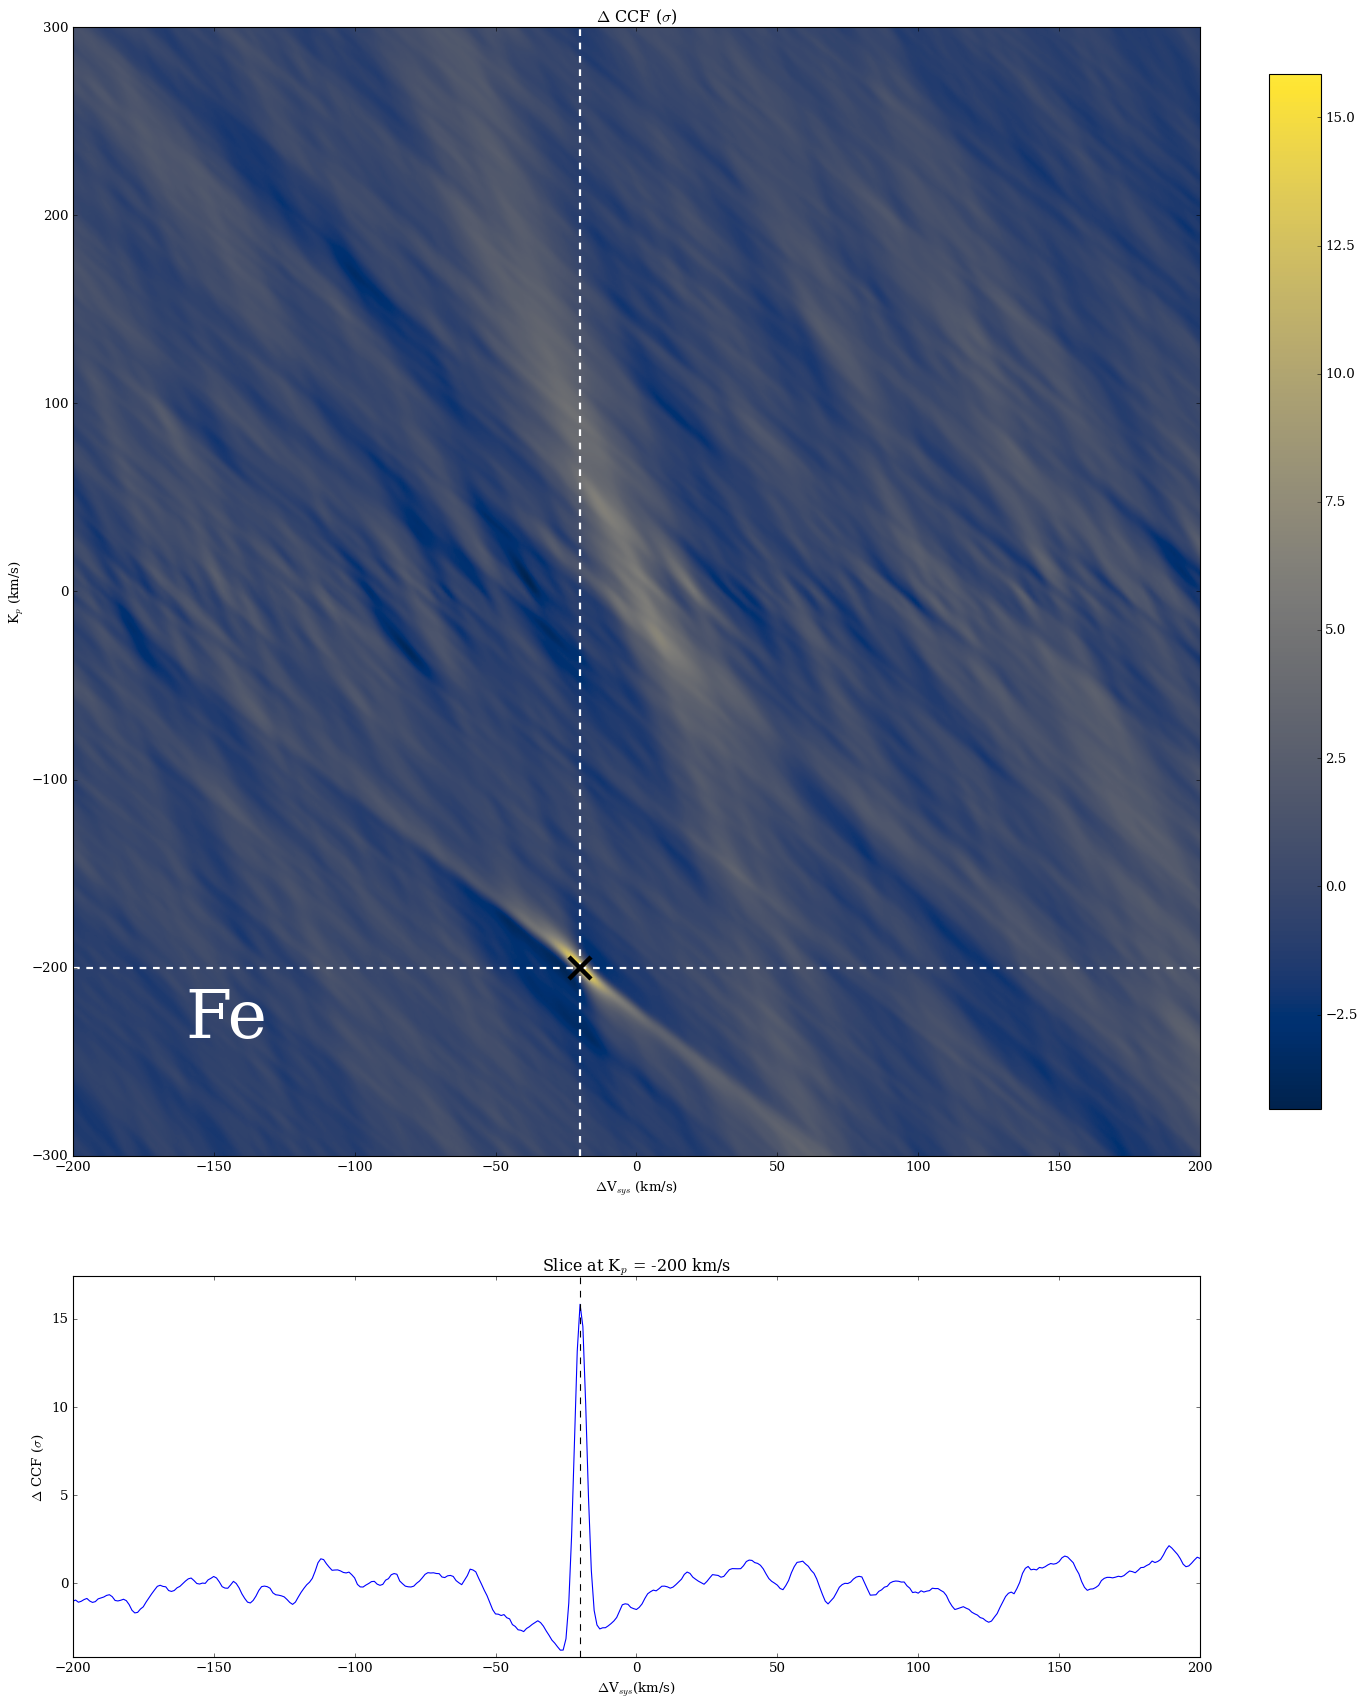

In [ ]:
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    -200,
    Vsys=-20,
    RM_mask_size=20,
    plot_label=True,
)